# Parker Solar Probe Examples

In [1]:
from utils.io import load_psp_data, time_stamp
from pytplot import tplot, tlimit, timebar
import pytplot
from utils.config import PSPConfig
from utils import td_start_c, td_stop_c

11-May-24 17:21:04: Retrying (Retry(total=4, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPConnectionPool(host='sciqlop.lpp.polytechnique.fr', port=80): Read timed out. (read timeout=1)")': /cache/get_inventory?provider=ssc
11-May-24 17:21:07: Retrying (Retry(total=3, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPConnectionPool(host='sciqlop.lpp.polytechnique.fr', port=80): Read timed out. (read timeout=1)")': /cache/get_inventory?provider=ssc
11-May-24 17:21:13: Retrying (Retry(total=2, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPConnectionPool(host='sciqlop.lpp.polytechnique.fr', port=80): Read timed out. (read timeout=1)")': /cache/get_inventory?provider=ssc
11-May-24 17:21:22: Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPConne

In [3]:
n = 10

In [4]:
tnames = load_psp_data()

0 : psp_fld_l2_mag_RTN_4_Sa_per_Cyc
1 : psp_swp_spi_sf00_L3_DENS
2 : psp_swp_spi_sf00_L3_VEL_RTN_SUN
3 : psp_swp_spi_sf00_L3_VEL_RTN
4 : psp_swp_spi_af00_L3_DENS
5 : psp_swp_spi_af00_L3_VEL_RTN_SUN
6 : psp_swp_spi_af00_L3_VEL_RTN
7 : Tp_spani_b
8 : Tp_spanib_b


In [6]:
import polars as pl
def keep_good_fit(df: pl.DataFrame):
    return df.filter(pl.col("fit.stat.rsquared") > 0.9)

def find_events(df: pl.DataFrame):
    return df.with_columns(
        Λ_t = 1 - (pl.col("v.ion.change.l") / pl.col("v.Alfven.change.l")) ** 2
    ).with_columns(
        rate =  (pl.col("Λ_ion") / pl.col("Λ_t") - 1).abs()
    ).sort("rate")
    
def unique_events(df: pl.DataFrame, subset: list[str] = [td_start_c, td_stop_c]):
    return df.unique(subset=subset)
    
p_conf = PSPConfig(enc=7).load()
events = find_events(p_conf.events).pipe(keep_good_fit).pipe(unique_events).head(n=n)

In [7]:
from datetime import timedelta


def plot_event(
    event,
    tnames2plot,
    td_stop_c="t.d_end",
    add_timebars=True,
    offset=timedelta(seconds=60),
):
    tstart = time_stamp(event["tstart"] - offset)
    tstop = time_stamp(event["tstop"] + offset)
    td_start = event["t.d_start"]
    td_stop = event[td_stop_c]

    tlimit([tstart, tstop])

    if add_timebars:
        timebar(time_stamp(td_start))
        timebar(time_stamp(td_stop))

    return tplot(tnames2plot, return_plot_objects=True)

In [8]:
from discontinuitypy.utils.plot import plot_candidate
from pytplot import get_data

def plot_candidate_tplot(event, name= 'psp_fld_l2_mag_RTN_4_Sa_per_Cyc'):
    da = get_data(name, xarray=True)
    return plot_candidate(event, da)

In [9]:
tnames2plot = [
    'psp_fld_l2_mag_RTN_4_Sa_per_Cyc',
    'psp_swp_spi_sf00_L3_DENS',
    'psp_swp_spi_sf00_L3_VEL_RTN_SUN',
    'Tp_spani_b'
]

In [10]:
from great_tables import GT

GT(events.select("tstart", "tstop", "Λ_t", "Λ_ion")).fmt_datetime(
    columns=["tstart", "tstop"]
).fmt_number(columns=["Λ_t", "Λ_ion"], decimals=2)

tstart,tstop,Λ_t,Λ_ion
2021-01-17 14:02:48,2021-01-17 14:03:04,0.70,0.92
2021-01-18 18:59:04,2021-01-18 18:59:20,0.45,0.22
2021-01-18 16:32:40,2021-01-18 16:32:56,0.59,0.20
2021-01-18 15:05:28,2021-01-18 15:05:44,0.40,0.11
2021-01-18 16:29:04,2021-01-18 16:29:20,1.00,0.22
2021-01-17 10:56:00,2021-01-17 10:56:16,0.74,0.15
2021-01-17 12:01:52,2021-01-17 12:02:08,0.99,0.18
2021-01-18 20:35:52,2021-01-18 20:36:08,0.48,0.08
2021-01-18 11:12:40,2021-01-18 11:12:56,1.00,0.17
2021-01-18 16:24:16,2021-01-18 16:24:32,0.82,0.13


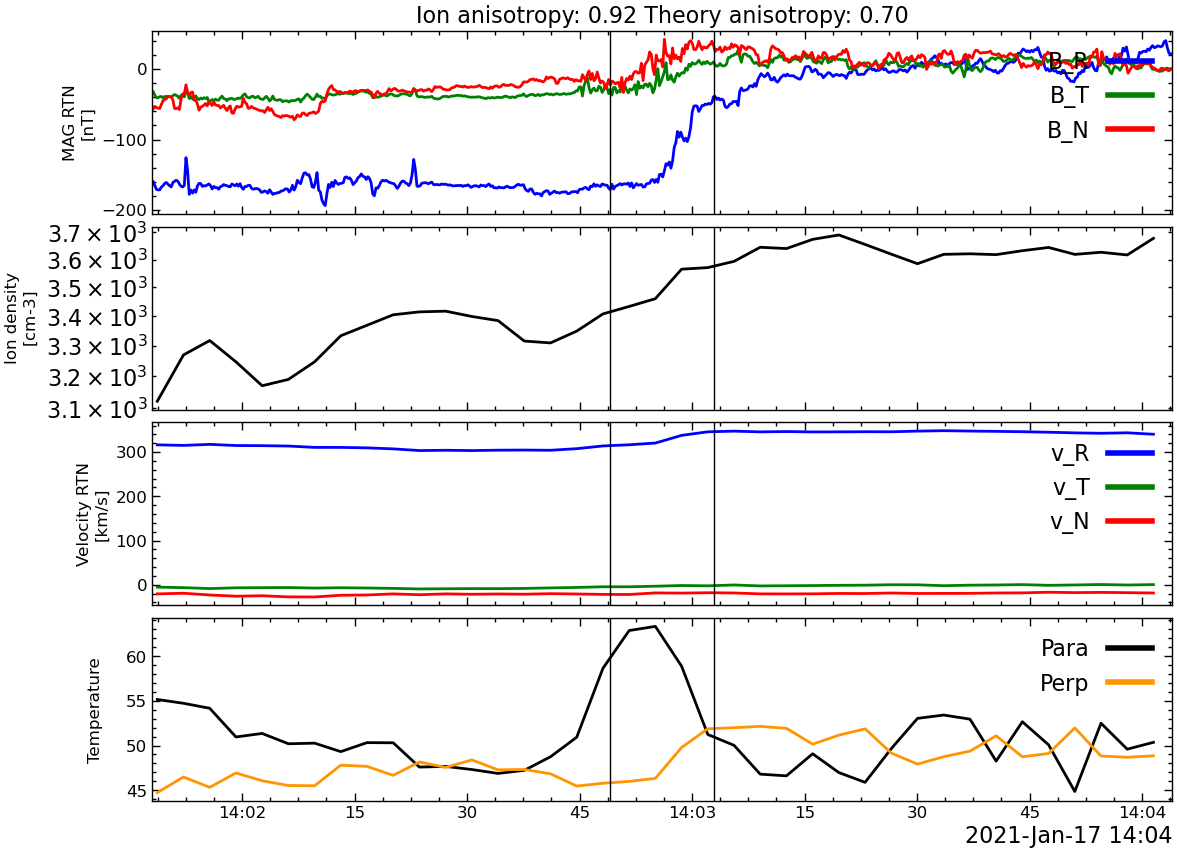

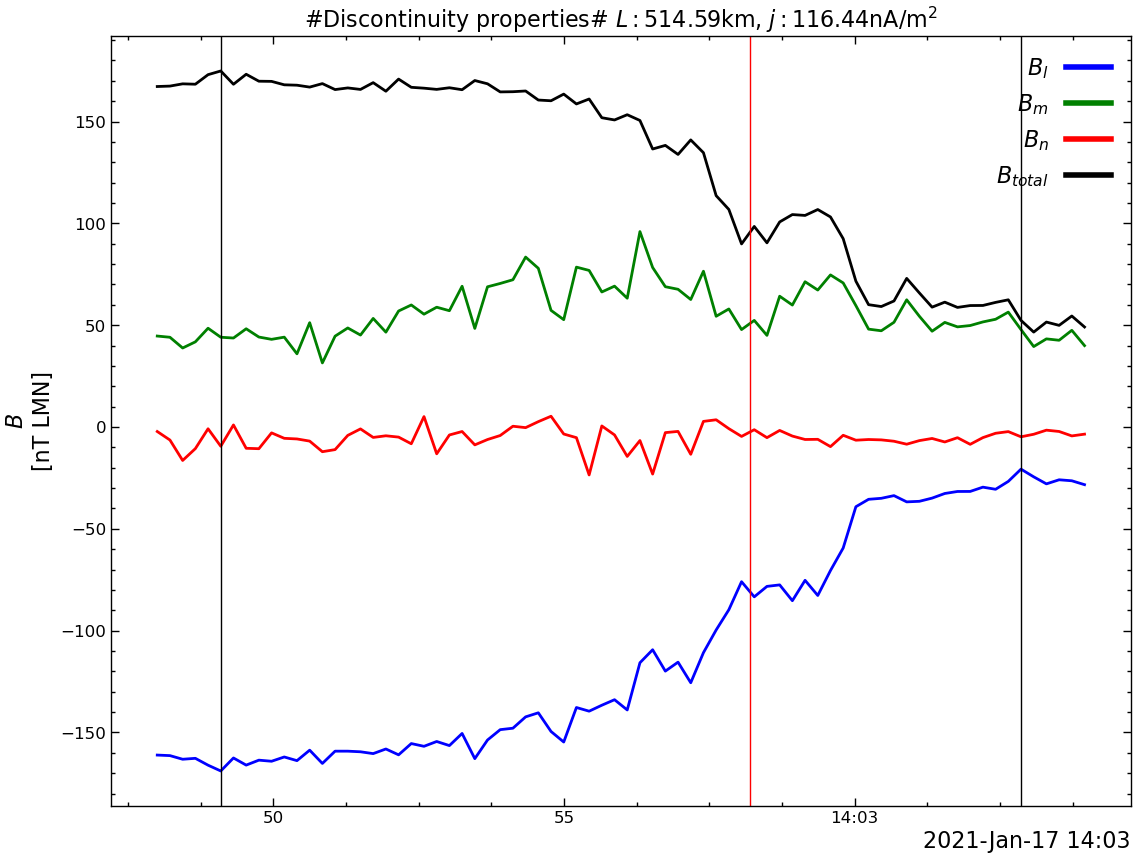

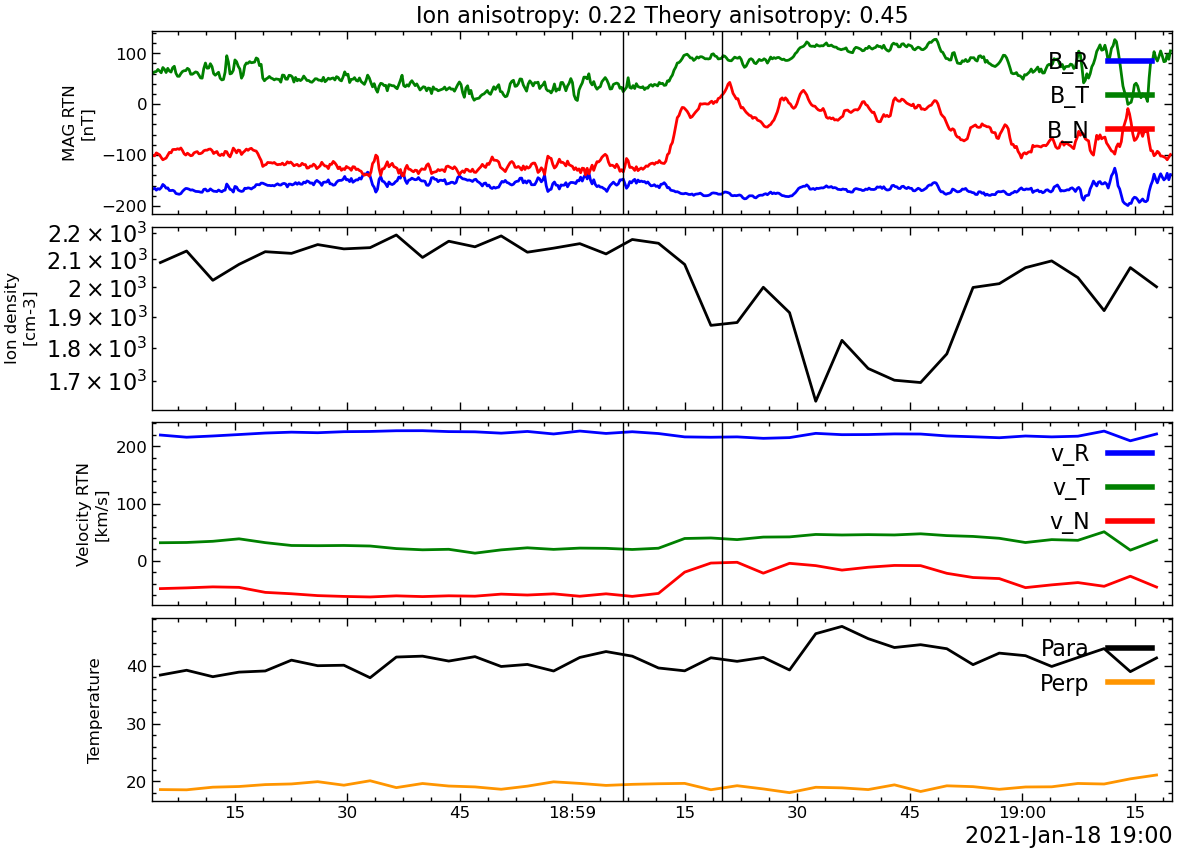

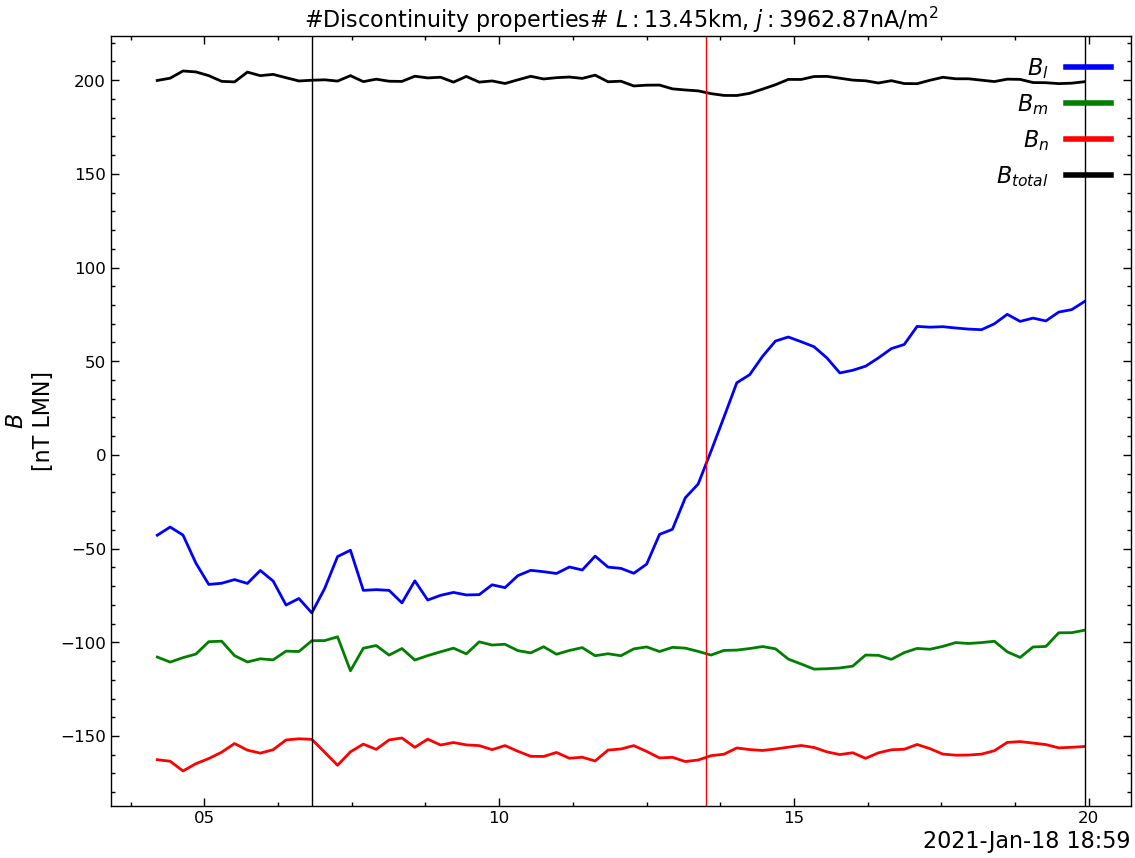

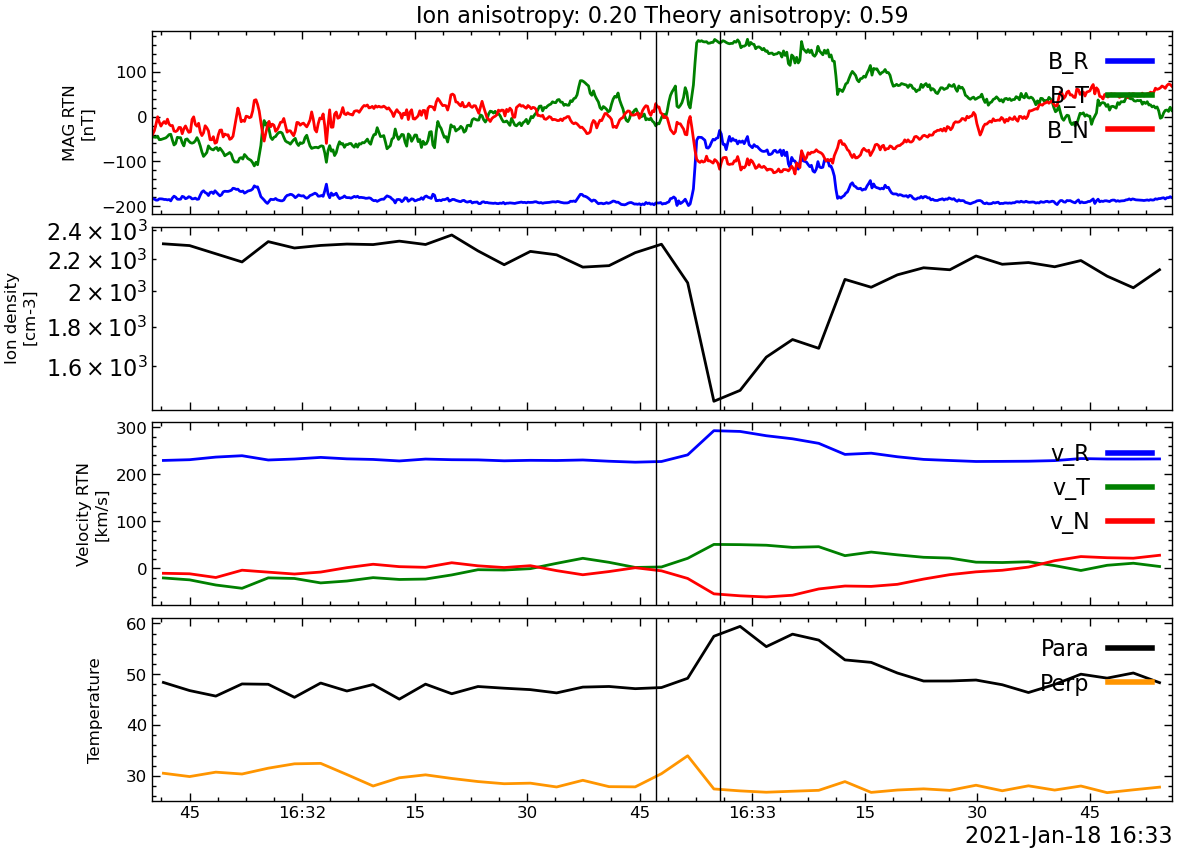

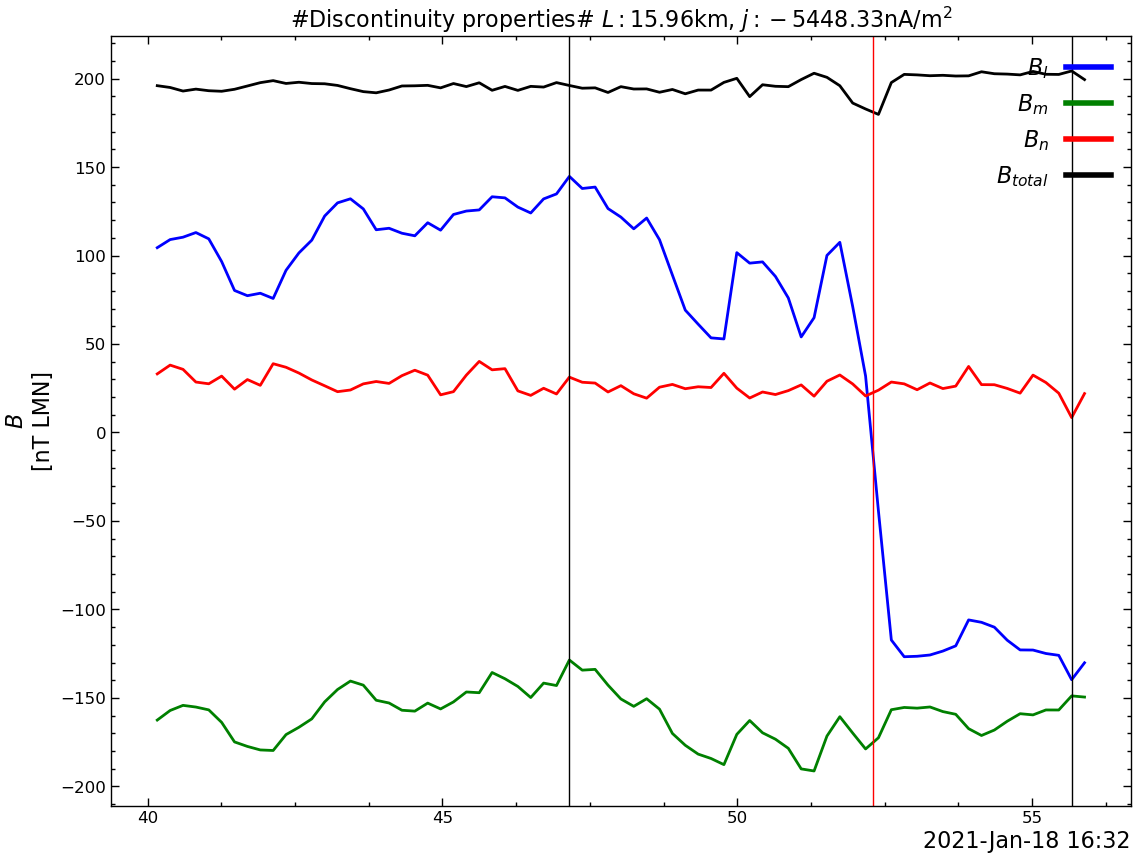

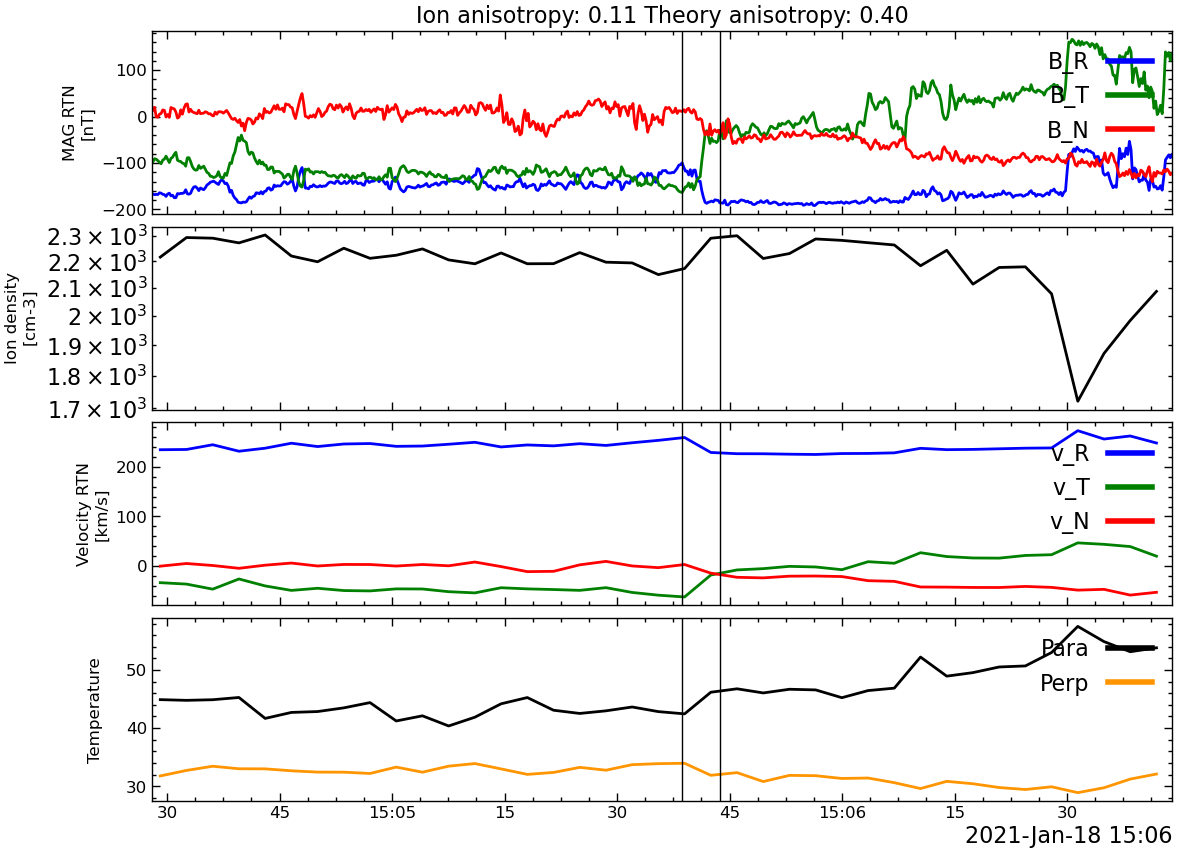

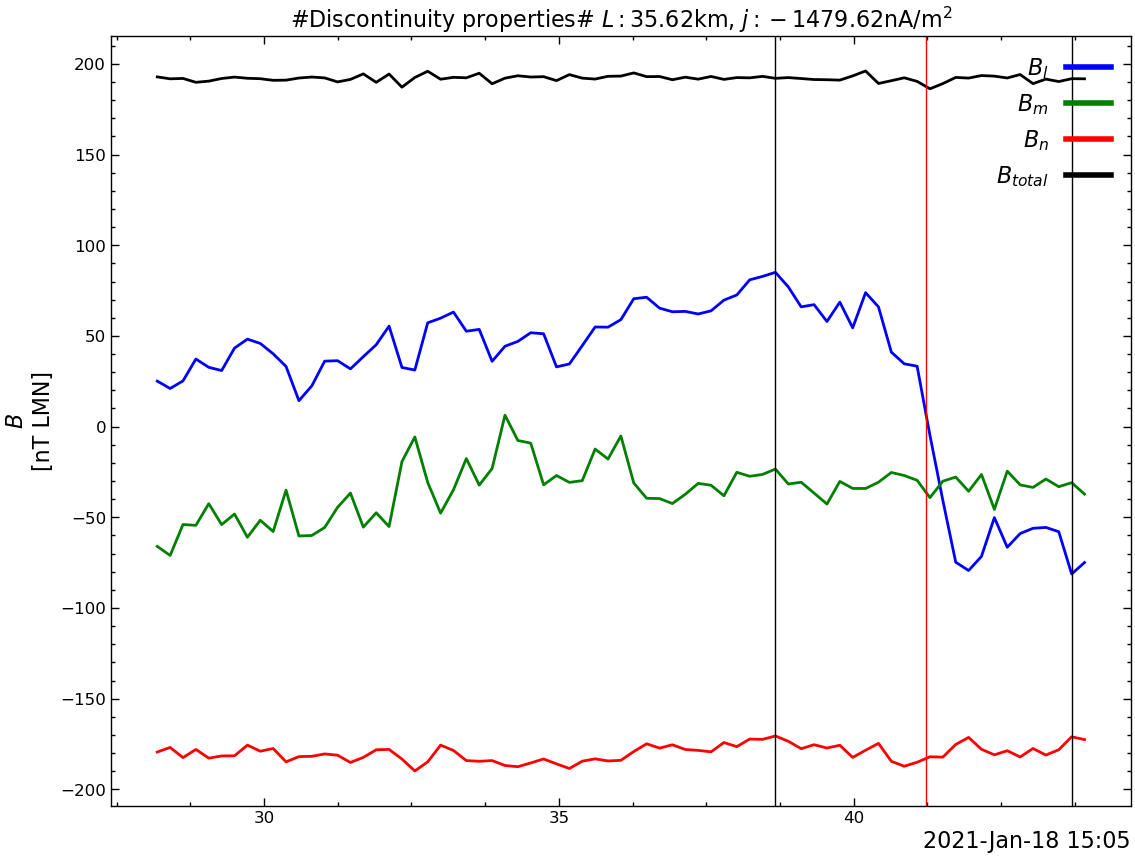

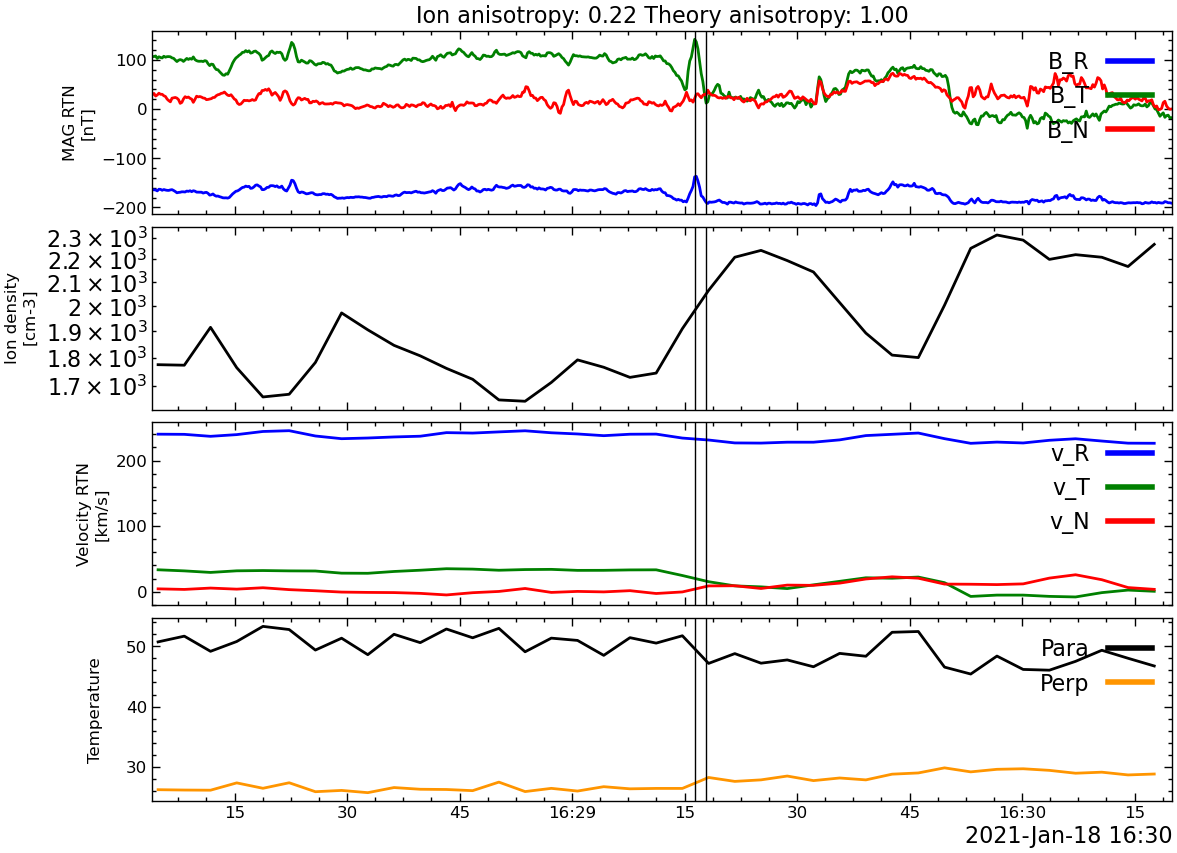

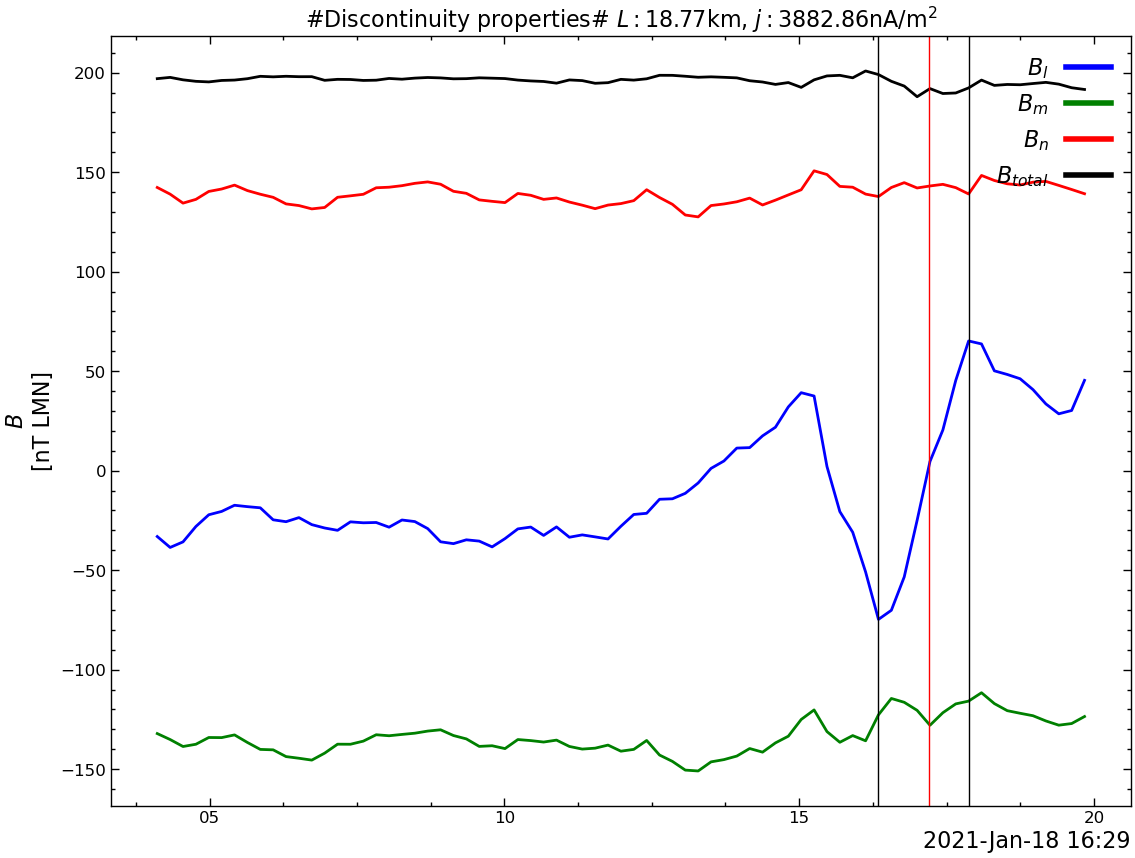

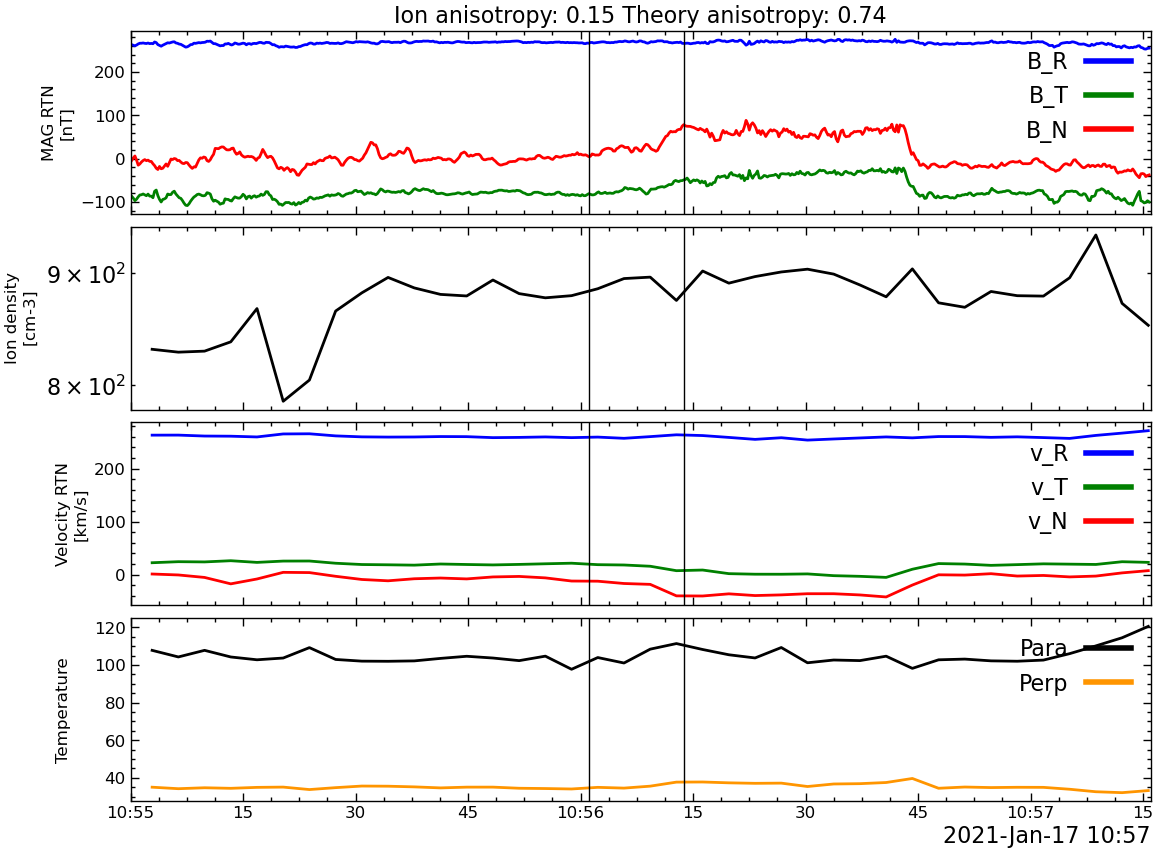

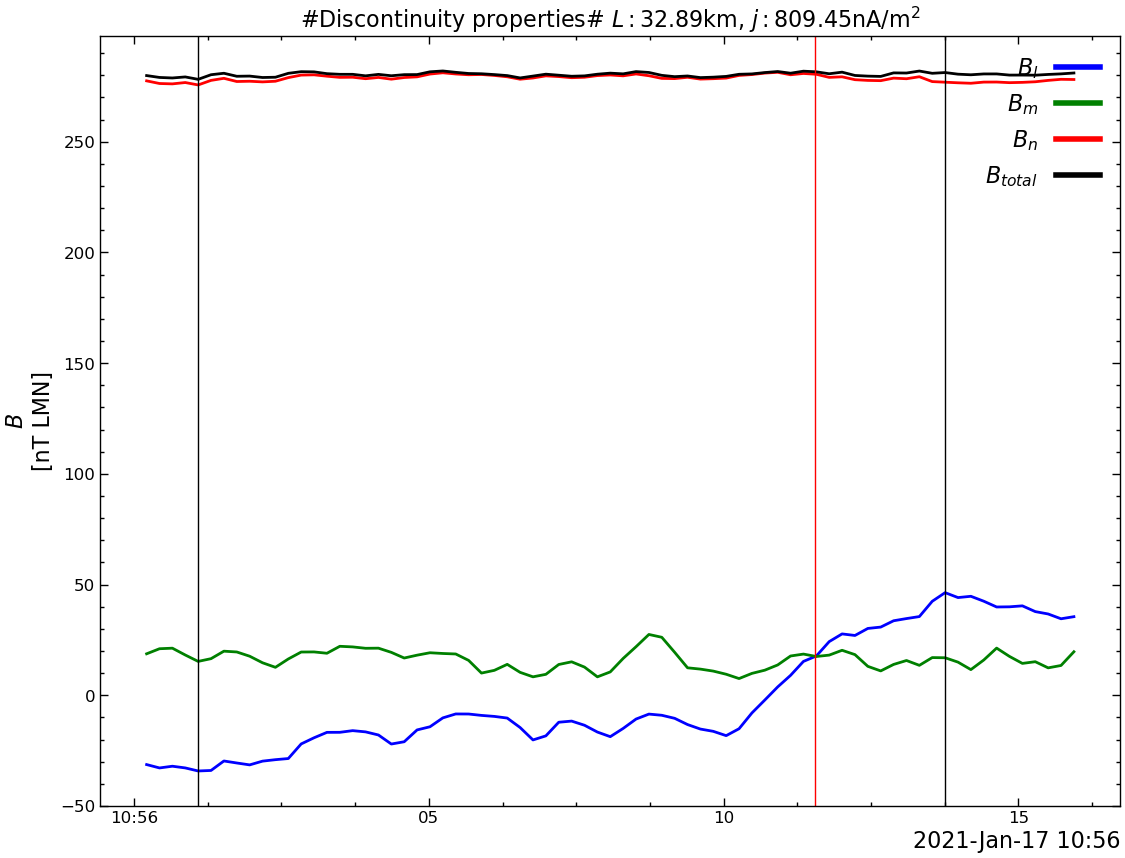

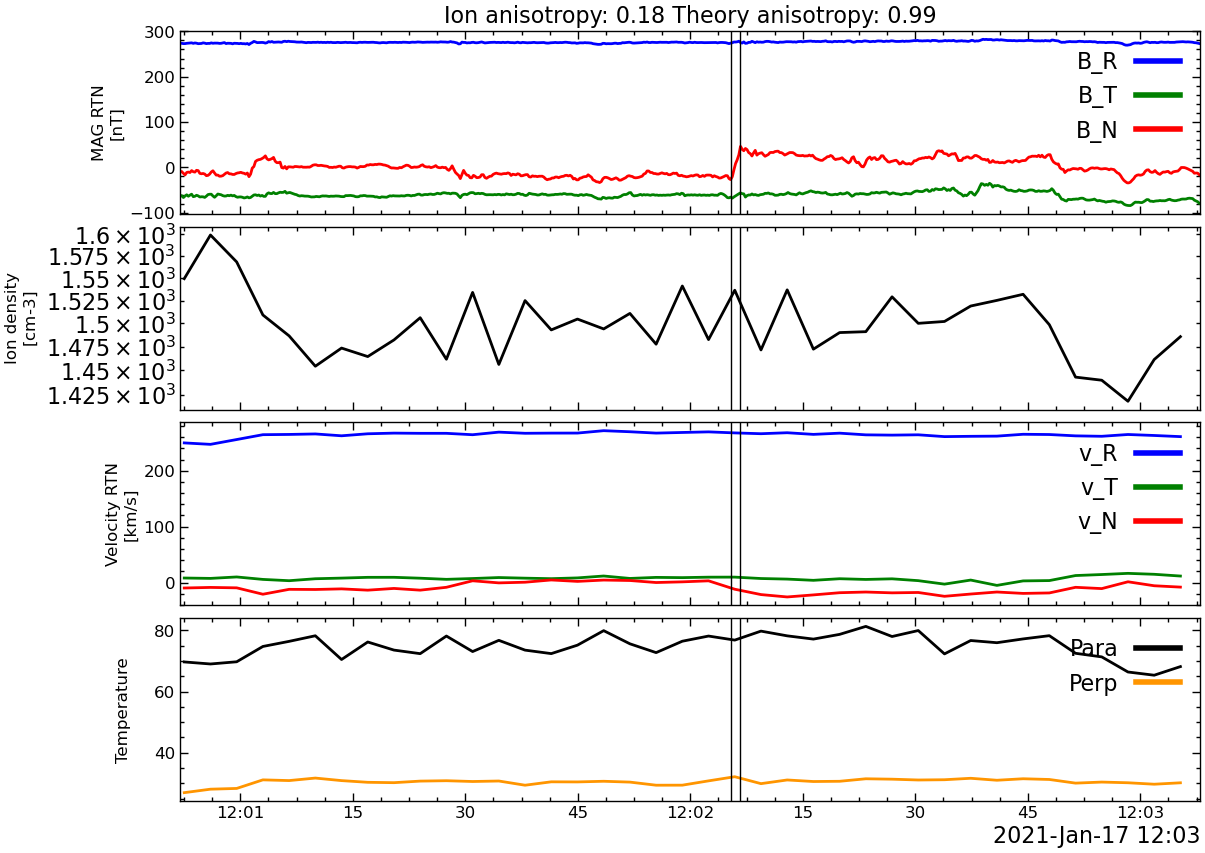

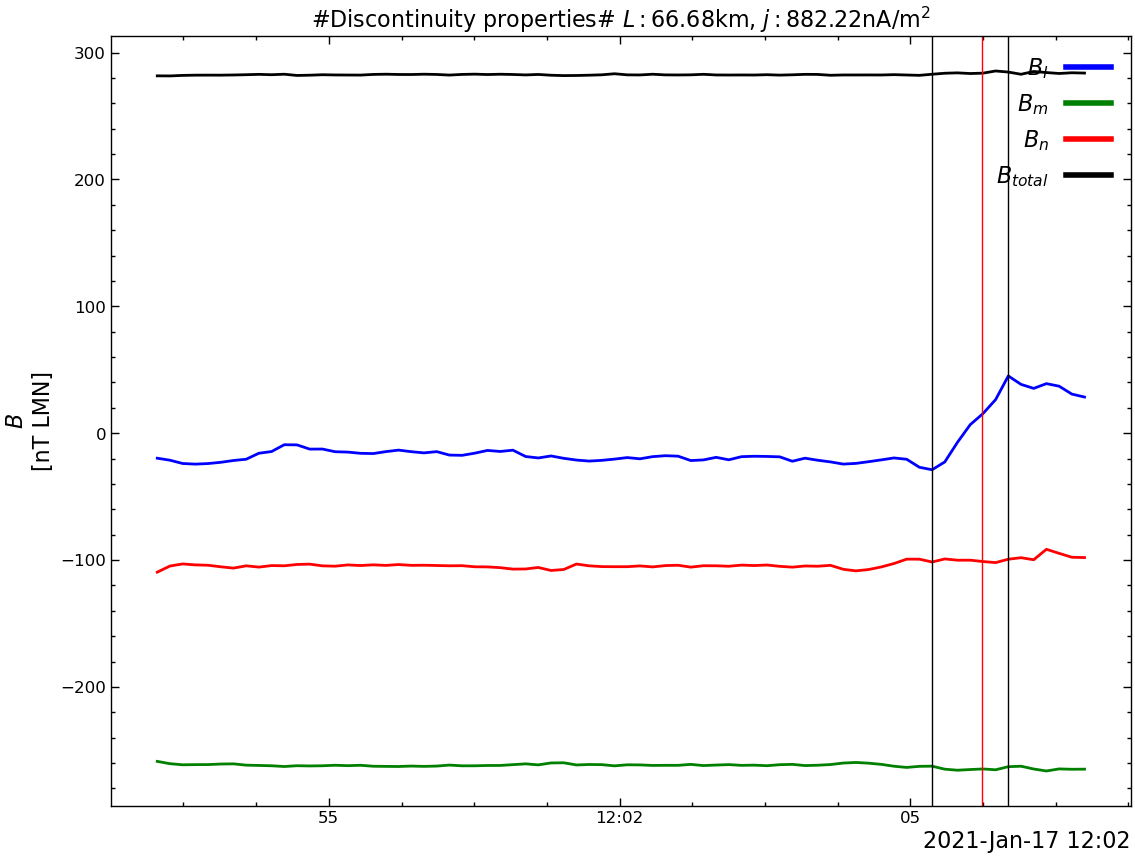

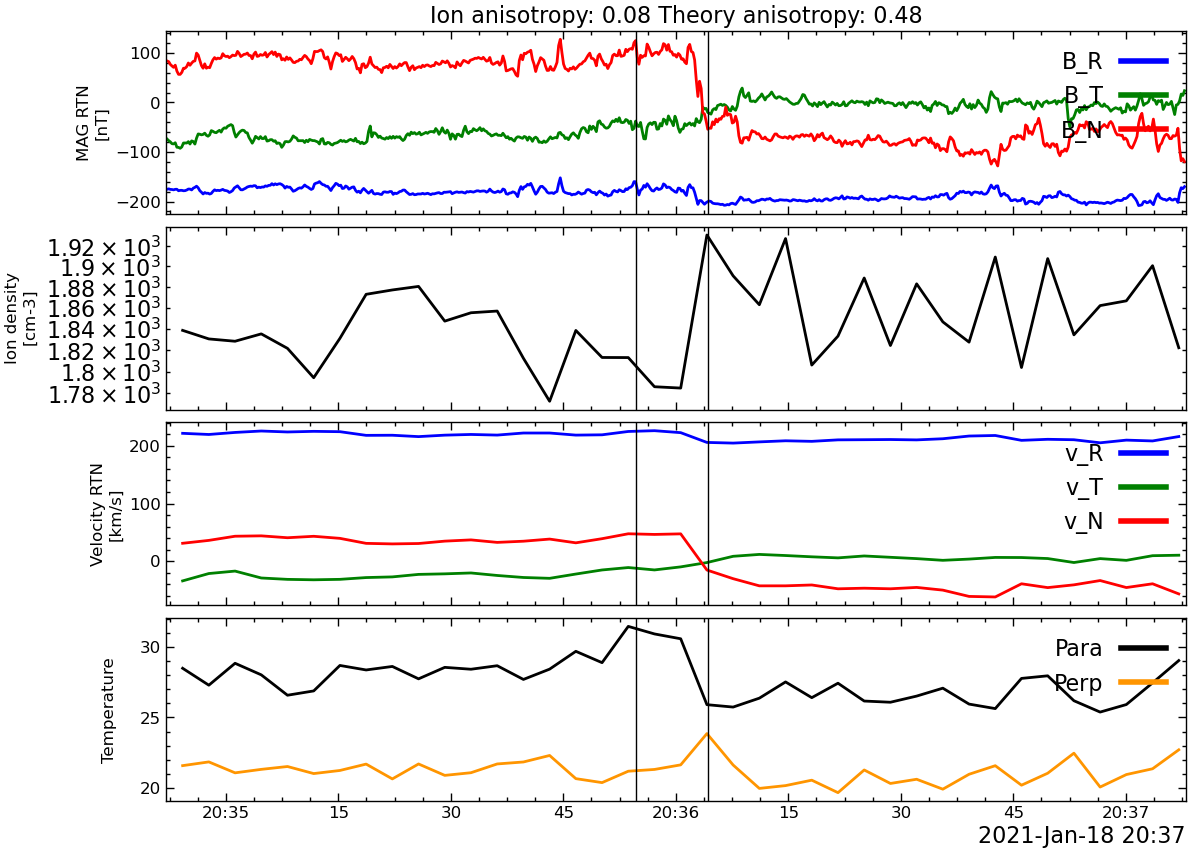

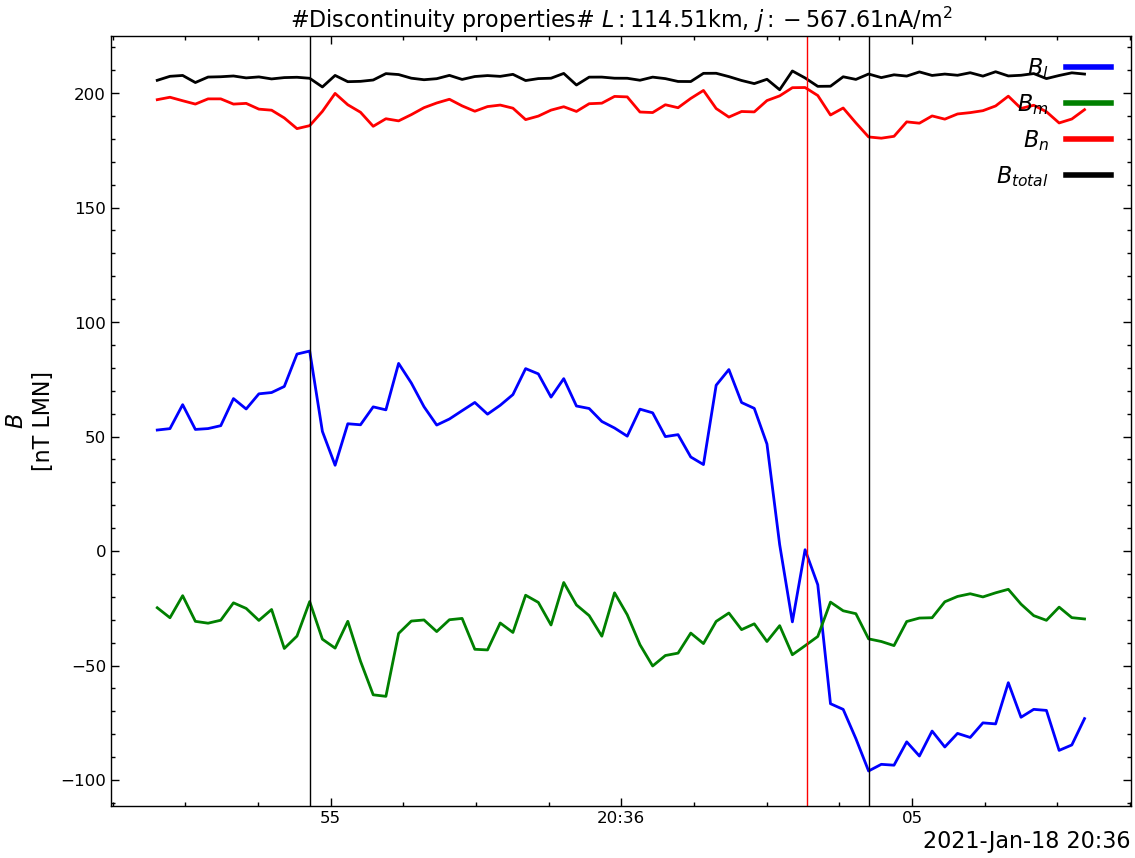

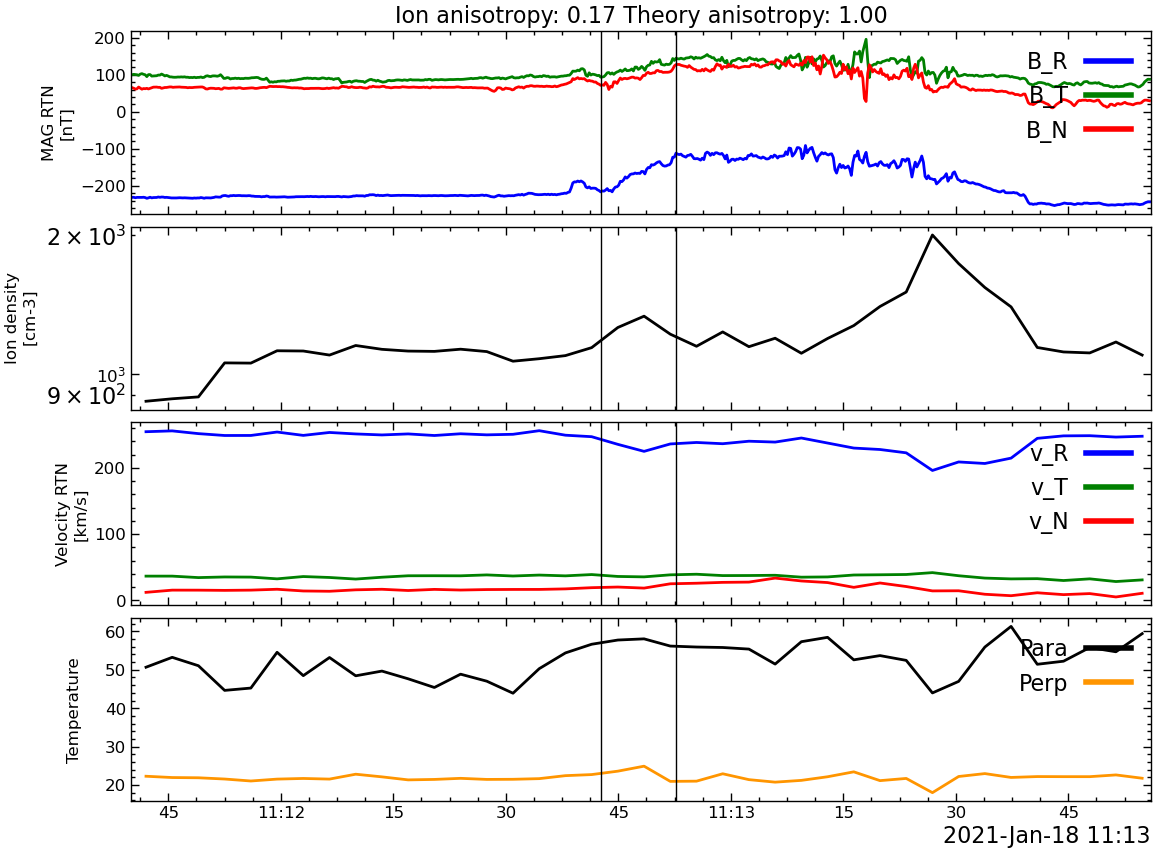

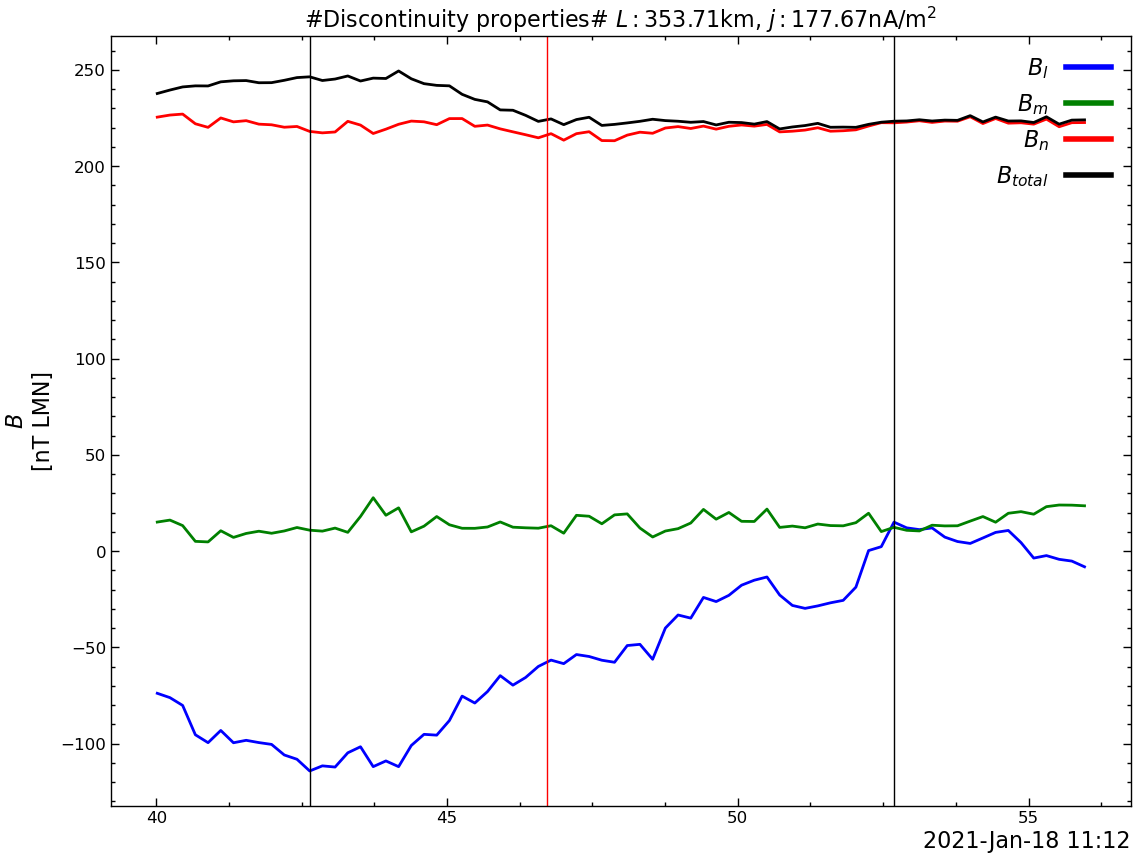

In [11]:
#| layout-ncol: 2
#| column: page
pytplot.tplot_options('ysize', 10)

title = "Ion anisotropy: {:.2f} Theory anisotropy: {:.2f}"

for event in events.rows(named=True):
    fig, axs = plot_event(event, tnames2plot)
    axs[0].set_title(title.format(event["Λ_ion"], event["Λ_t"]))
    tlimit('full')
    plot_candidate_tplot(event)